In [1]:
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import datetime

In [2]:
frequency_dict = {'1m':390, '5m':78, '15m':26, '60m':6.5, '1d':1}

In [3]:
def get_data(symbol, frequency):
    data = yf.download(symbol, period="8d", interval=frequency)  
    close = np.array(data['Close']).flatten()  
    high = np.array(data['High']).flatten() 
    
    plt.plot(close)
    plt.title(f'{symbol} Close Prices by {frequency}')
    plt.grid()
    plt.show()
    
    date_str = datetime.today().strftime('%Y-%m-%d')
    np.save(f'{symbol}-{date_str}-close.npy', close)
    np.save(f'{symbol}-{date_str}-high.npy', high)
    
    return close, high

In [4]:
def instanteous_volatility(close_prices):
    r = np.diff(np.log(close_prices))
    index_max = np.argmax(r)
    r = r[index_max:]
    
    vt = r**2
    results = {}

    # Check volatility structure in return
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    plot_acf(vt, ax=ax[0], lags=30)
    ax[0].set_title("ACF of $r_t^2$ ")

    # Test whether autocorrelation exists -> if not, volatility may not need modeling 
    lb_test = acorr_ljungbox(vt, lags=[10], return_df=True)
    
    # Fit ARCH
    arch = arch_model(r, vol='ARCH', p=1, rescale=False)
    fit_arch = arch.fit(disp="off")
    resid_arch = fit_arch.resid / fit_arch.conditional_volatility
    resid_sq_arch = resid_arch ** 2

    # Fit GARCH
    garch = arch_model(r, vol='GARCH', p=1, q=1, rescale=False)
    fit_garch = garch.fit(disp="off")
    resid_garch = fit_garch.resid / fit_garch.conditional_volatility
    resid_sq_garch = resid_garch ** 2

    # Plot acf of residuals & test autocorrelation
    plot_acf(resid_sq_arch, ax=ax[1], lags=30)
    ax[1].set_title("ACF of ARCH(1) standardized residuals squared")
    plot_acf(resid_sq_garch, ax=ax[2], lags=30)
    ax[2].set_title("ACF of GARCH(1,1) standardized residuals squared")
    plt.tight_layout()
    plt.show()

    lb_arch = acorr_ljungbox(resid_sq_arch, lags=[10], return_df=True)
    lb_garch = acorr_ljungbox(resid_sq_garch, lags=[10], return_df=True)

    results['return_lb_pvalue'] = lb_test['lb_pvalue'].values[0]
    results['arch_bic'] = fit_arch.bic
    results['garch_bic'] = fit_garch.bic
    results['arch_resid_sq_lb_pvalue'] = lb_arch['lb_pvalue'].values[0]
    results['garch_resid_sq_lb_pvalue'] = lb_garch['lb_pvalue'].values[0]
    print(results)
    
    if lb_test['lb_pvalue'].values[0] > 0.05:
        print('Realized vlatility selected!')
        return r, vt
    
    if (fit_arch.bic <= fit_garch.bic) and lb_arch['lb_pvalue'].values[0] > 0.05 :
        print('ARCH modeled volatility selected!')
        return r, fit_arch.conditional_volatility**2
    else:
        print('GARCH modeled volatility selected!')
        return r, fit_garch.conditional_volatility**2    


In [5]:
def log_likelihood(params, r, vt, interval):
    r, vt = r * interval, vt * interval
    vt = np.maximum(vt, min(vt[np.nonzero(vt)]))
    
    delta_vt = np.diff(vt)
    r, vt = r[1:], vt[1:]

    mu, kappa, theta, sigma, rho = params
    dt = 1 / 252 
    vt = vt / dt # Annualize to match the unit of parameters
    
    mu_r = mu - 0.5 * vt
    mu_delta_vt = kappa * (theta - vt)

    res_r = r - mu_r * dt
    res_dv = delta_vt - mu_delta_vt * dt

    # Construct vector of residuals shape (T, 2)
    X = np.stack([res_r, res_dv], axis=1)

    # Preallocate log-likelihood
    logL = 0

    for i in range(len(vt)):
        v = vt[i]
        Sigma = dt * np.array([
            [v, rho * sigma * v],
            [rho * sigma * v, sigma**2 * v]
        ])
        try:
            inv_Sigma = np.linalg.inv(Sigma)
            det_Sigma = np.linalg.det(Sigma)
        except np.linalg.LinAlgError:
            continue  # skip ill-conditioned step

        diff = X[i]
        maha = diff @ inv_Sigma @ diff.T
        logL += -0.5 * (np.log(det_Sigma) + maha )

    return -logL

In [6]:
def MLE_fit(r, vt, interval):
    init_params = [0.01, 1.0, 0.1, 0.1, -0.5]  # intial mu, kappa, theta, sigma, rho

    # Bound
    bounds = [
        (-2, 2),     # mu: stock price moving direction and speed. mu = 1 -> stock price doubles a year
        (1e-6, 10),  # kappa: volatility mean reverting speed, must be positive
        (1e-6, 10),   # theta: long term volatility, must be positive
        (1e-6, 10),   # sigma: volatility of volatility
        (-0.999, 0.999)  # rho: the correlation bewtween two Brownian motions in the Heston model. Can't be 1 or -1, or matrix computation goes wrong
    ]

    result = minimize(
        log_likelihood,
        init_params,
        args=(r, vt, interval),
        bounds=bounds,
        method='L-BFGS-B', 
        options={'disp': True, 'maxiter': 500}
    )

    print("Success:", result.success)
    print("Fitted parameters (mu, kappa, theta, sigma, rho):", result.x)
    print("Log-likelihood value:", -result.fun)
    
    return result.x

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


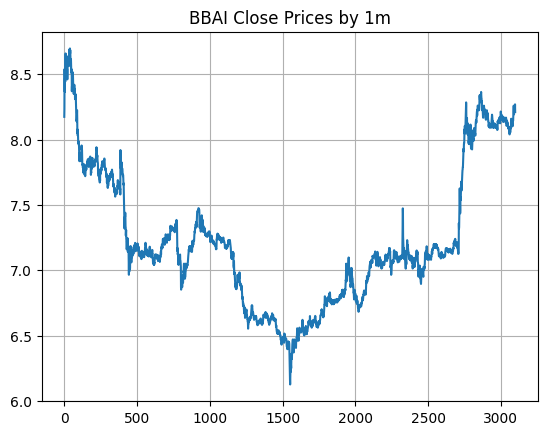

c:\Users\insan\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


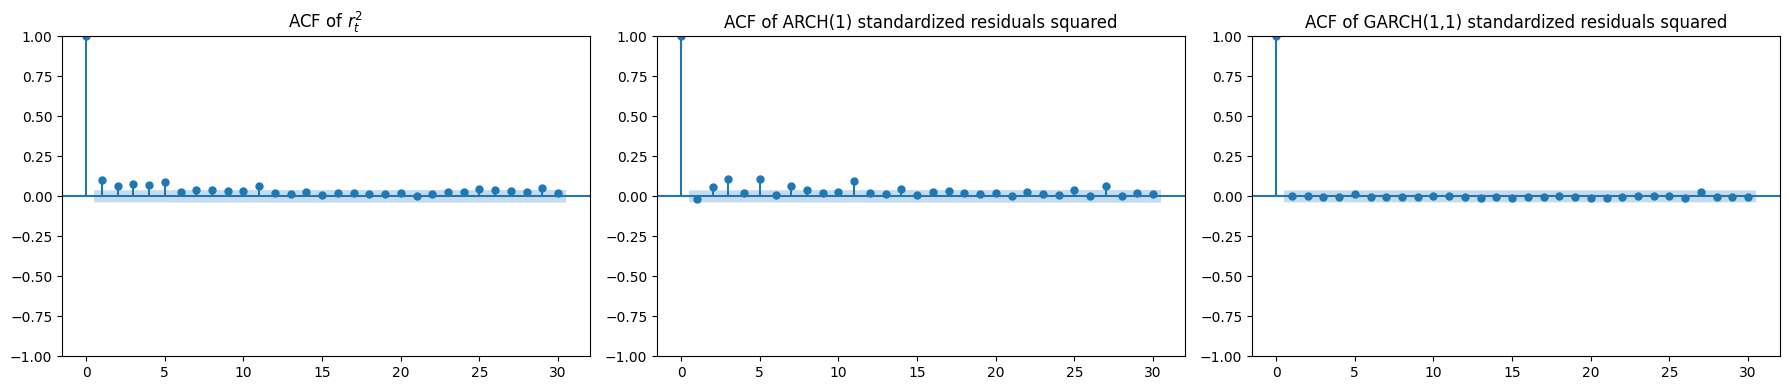

{'return_lb_pvalue': 1.5058889950919944e-18, 'arch_bic': -23992.872730674262, 'garch_bic': -24351.44171755873, 'arch_resid_sq_lb_pvalue': 7.452522798130462e-16, 'garch_resid_sq_lb_pvalue': 0.9997097748048175}
GARCH modeled volatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [ 2.00000000e+00  1.00000000e-06  1.00000000e+01  1.05825680e-02
 -1.24956555e-03]
Log-likelihood value: -536103.6524511982


In [7]:
frequency = '1m'
interval = frequency_dict[frequency]     
close, high = get_data('BBAI', frequency) 
r, vt = instanteous_volatility(close)
params = MLE_fit(r, vt, interval)

In [8]:
def barrier_breach_monte_carlo(params, s0, v0, v_min, barrier, interval, steps, n):
    mu, kappa, theta, sigma, rho = params
    dt = 1 / (interval * 252) # in yearly measurement
    breaches = 0
    
    for trial in range(n):
        st = s0
        vt = v0
        prob = 1
        breached = None
        for step in range(steps):
            z1 = np.random.normal(0, 1)  # For dW1 (stock)
            z2 = np.random.normal(0, 1)  # For independent noise
            dw1 = z1 * np.sqrt(dt)
            dw2 = (rho * z1 + np.sqrt(1 - rho**2) * z2) * np.sqrt(dt)
            
            st_1 = st
            st += mu * st * dt + np.sqrt(vt) * st * dw1
            vt += kappa * (theta - vt) * dt + sigma * np.sqrt(vt) * dw2
            vt = max(vt, v_min) # in case vt gets negative
            
            if st > barrier:
                breached = True
                break
            
            prob_step = np.exp((- 2 * np.log(st_1 / barrier) * np.log(st / barrier))/ (vt * dt))
            prob_step = np.clip(prob_step, 0, 1)
            prob = prob * (1 - prob_step)
            
        if breached:
            breaches += 1
        else:
            breaches += (1 - prob)
            
    return breaches/n

In [9]:
def breaches(high, barrier):
    breach = np.sum(high > barrier)
    return breach / len(high)


In [10]:
def barrier_breach_prob_test(symbol, frequency, adjustments, n): 
    interval = frequency_dict[frequency] 
    
    close, high = get_data(symbol, frequency) 
    split = len(close) - 390 # remove data of the last trading day, maximum 390 minutes
    train_close = close[:split]
    test_high = high[split:]
    
    r, vt = instanteous_volatility(train_close)
    params = MLE_fit(r, vt, interval)
    
    barriers = np.max(high[:split]) + adjustments
    monte_carlo_probs = []
    breach_ratios = []
    
    for barrier in barriers:
        
        s0 = train_close[-1]
        v_min = min(vt[np.nonzero(vt)])
        v0 = max(vt[-1], v_min) 
        v0, v_min = v0 * interval * 252, v_min * interval * 252 # Annualize
        
        monte_carlo_prob = barrier_breach_monte_carlo(params, s0, v0, v_min, barrier, interval, len(test_high), n)
        breach_ratio = breaches(test_high, barrier)
        
        monte_carlo_probs.append(monte_carlo_prob)
        breach_ratios.append(breach_ratio)
        
        # print('Monte Carlo Barrier Breach Probability: ', monte_carlo_prob)
        # print('Barrier Breach Ratio: ', breach_ratio) 
    
    plt.plot(adjustments, monte_carlo_probs, label='Simulated Barrier Breach Probabilities')
    plt.plot(adjustments, breach_ratios, label='Breach Ratio')

    plt.xlabel('Barrier level, adjustments from the highest price observed')
    plt.ylabel(f'{symbol}')
    plt.title('Probabilities changes against barrier changes')
    plt.legend()
    plt.grid(True)
    plt.show()

[*********************100%***********************]  1 of 1 completed


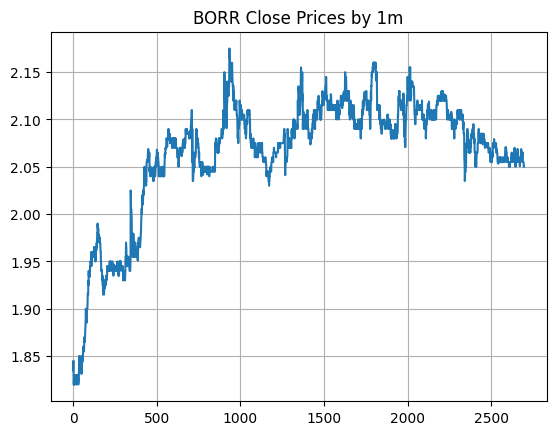

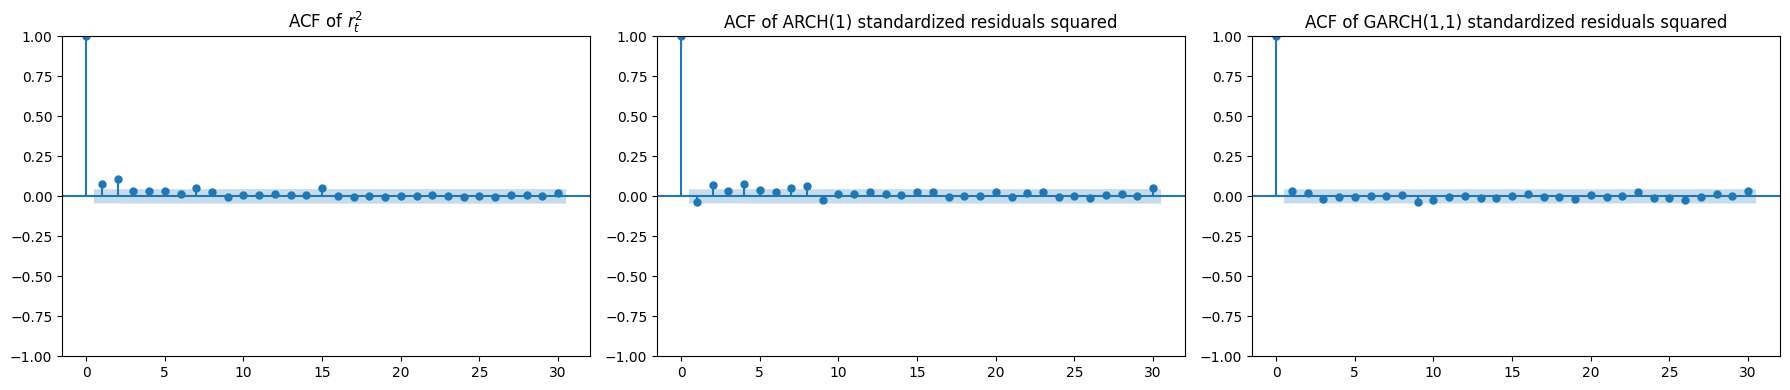

{'return_lb_pvalue': 3.138543618920906e-07, 'arch_bic': -17383.50585986613, 'garch_bic': -17471.540116201573, 'arch_resid_sq_lb_pvalue': 1.2531664156040943e-06, 'garch_resid_sq_lb_pvalue': 0.658376850238886}
GARCH modeled volatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [1.61032796e-01 1.00000000e-06 5.61998344e-01 1.05141885e-02
 5.69931274e-04]
Log-likelihood value: -337420.0134681302


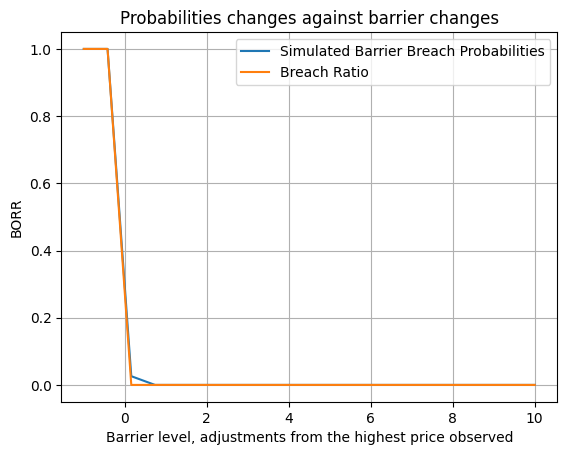

In [297]:
adjustments = np.linspace(-1, 10, 20)
barrier_breach_prob_test('BORR','1m', adjustments, 1000)

[*********************100%***********************]  1 of 1 completed


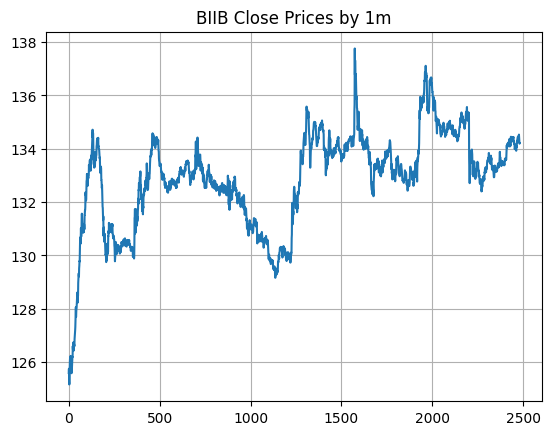

c:\Users\insan\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


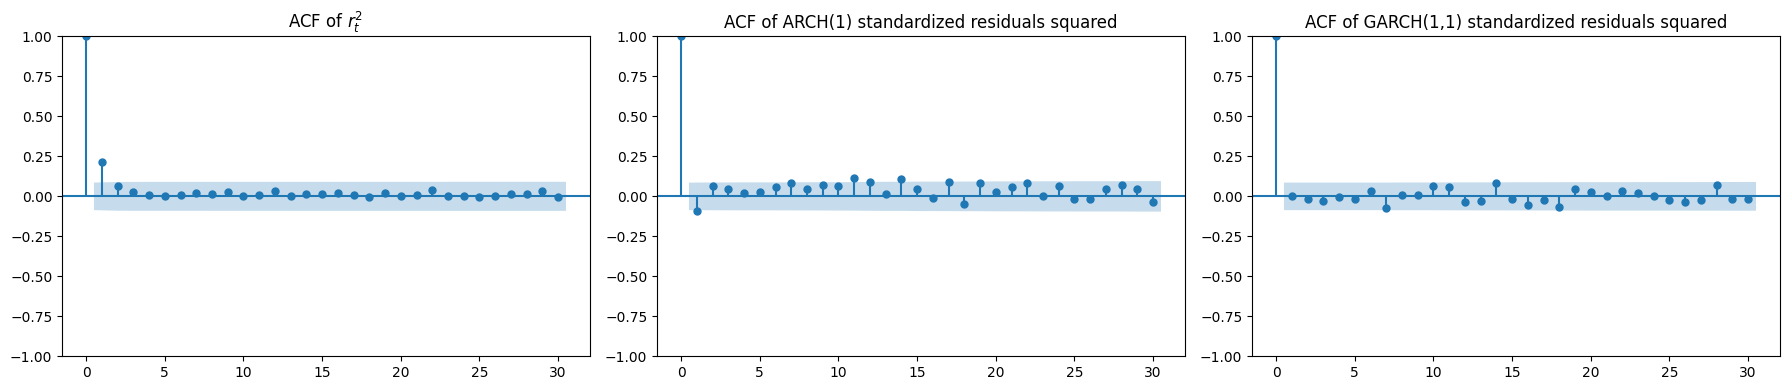

{'return_lb_pvalue': 0.0021605140720091227, 'arch_bic': -5464.139171975491, 'garch_bic': -5499.609464342948, 'arch_resid_sq_lb_pvalue': 0.03419175674584262, 'garch_resid_sq_lb_pvalue': 0.7648005239034372}
GARCH modeled volatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [-2.00000000e+00  1.00000000e-06  2.92249280e-01  4.53123729e-03
  2.43699455e-03]
Log-likelihood value: -83382.13802372452


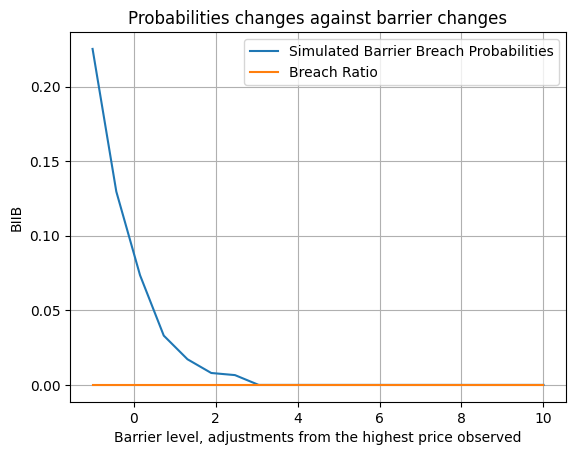

In [298]:
barrier_breach_prob_test('BIIB','1m', adjustments, 1000)

[*********************100%***********************]  1 of 1 completed


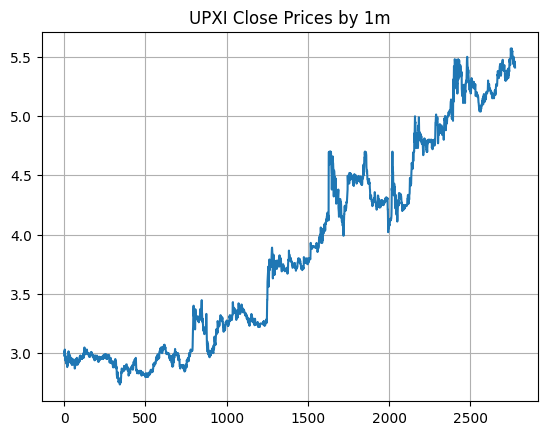

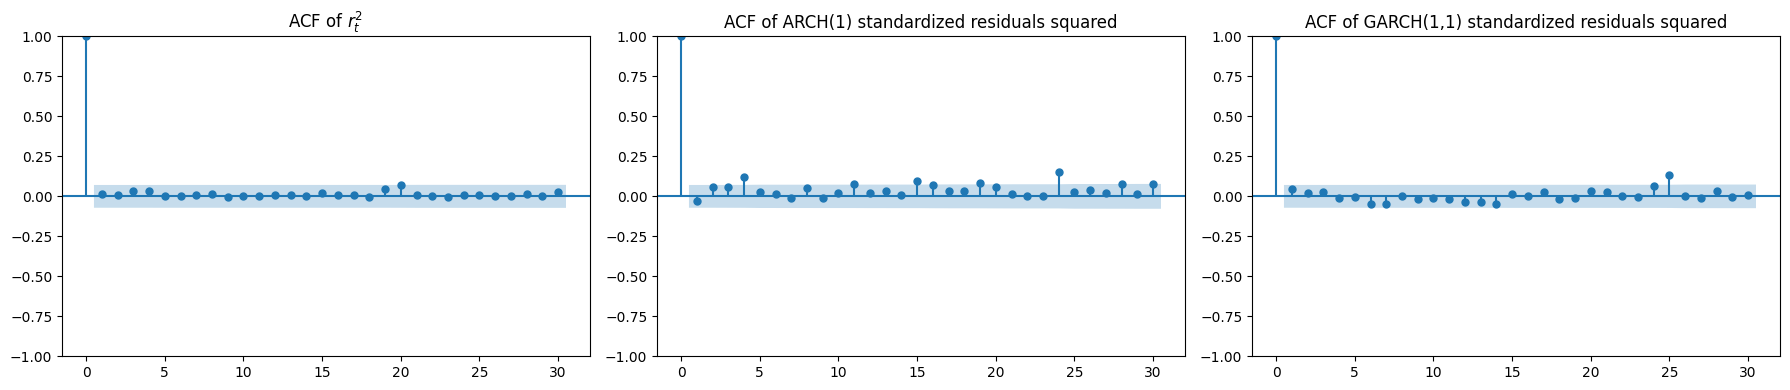

{'return_lb_pvalue': 0.9944954476681958, 'arch_bic': -5198.76945546149, 'garch_bic': -5266.729581869915, 'arch_resid_sq_lb_pvalue': 0.021115878829854613, 'garch_resid_sq_lb_pvalue': 0.7731843262434106}
Realized vlatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [-6.57753353e-02  5.16484001e-02  1.00000000e-06  1.00000000e+01
 -1.65045164e-04]
Log-likelihood value: -1550633.0312223854


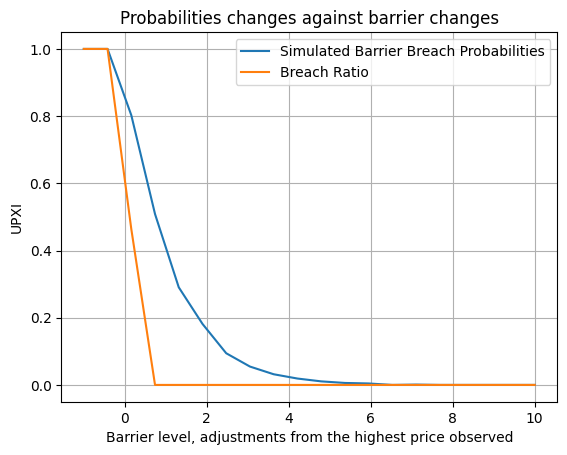

In [299]:
barrier_breach_prob_test('UPXI','1m', adjustments, 1000)

[*********************100%***********************]  1 of 1 completed


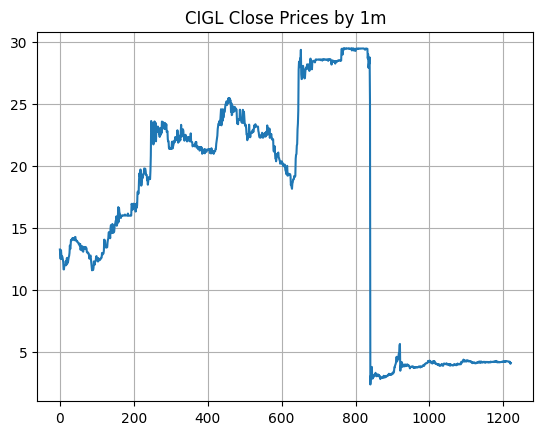

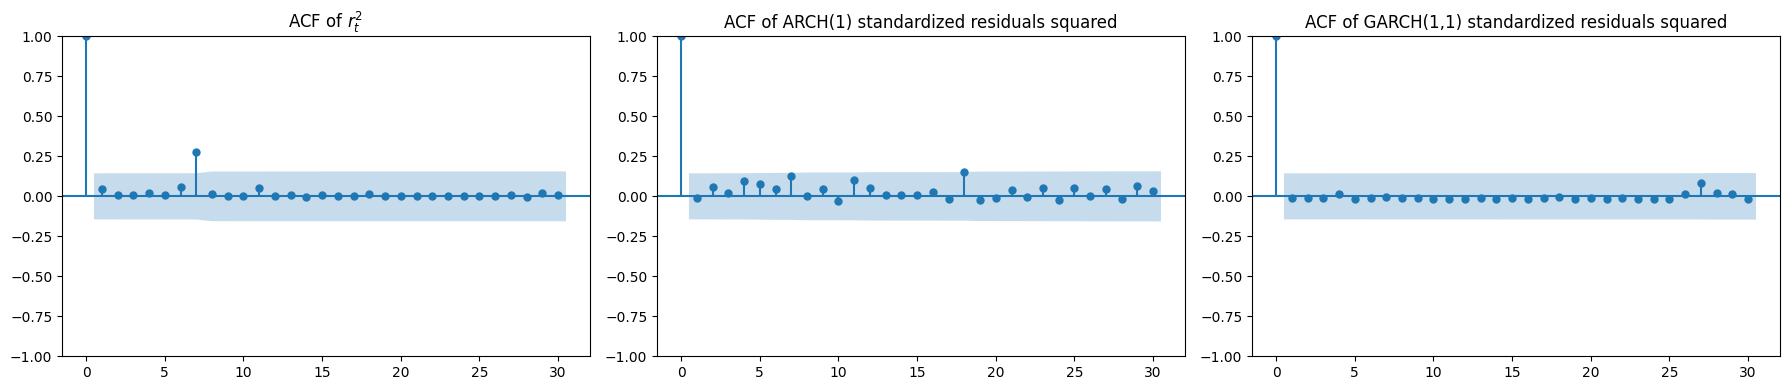

{'return_lb_pvalue': 0.10406139532013052, 'arch_bic': -1327.7912685898918, 'garch_bic': -1361.1001495992589, 'arch_resid_sq_lb_pvalue': 0.6447907159575224, 'garch_resid_sq_lb_pvalue': 0.999999711373892}
Realized vlatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [-4.80576880e-02  6.33421916e-01  1.00000000e-06  3.12163184e+00
 -6.10982383e-03]
Log-likelihood value: -32282.472736046824


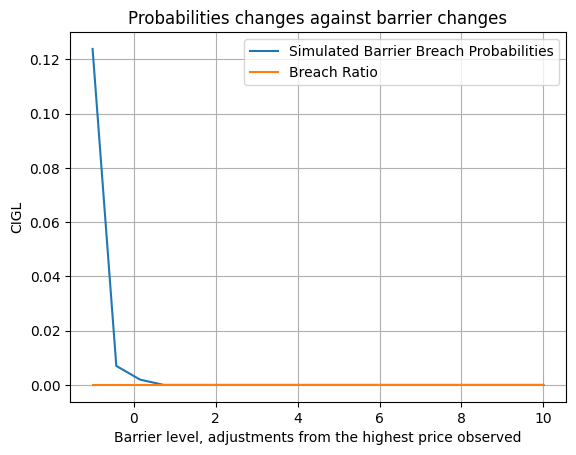

In [300]:
barrier_breach_prob_test('CIGL','1m', adjustments, 1000)

[*********************100%***********************]  1 of 1 completed


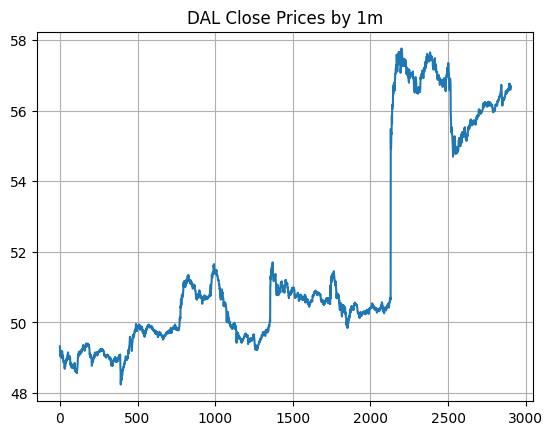

c:\Users\insan\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\insan\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


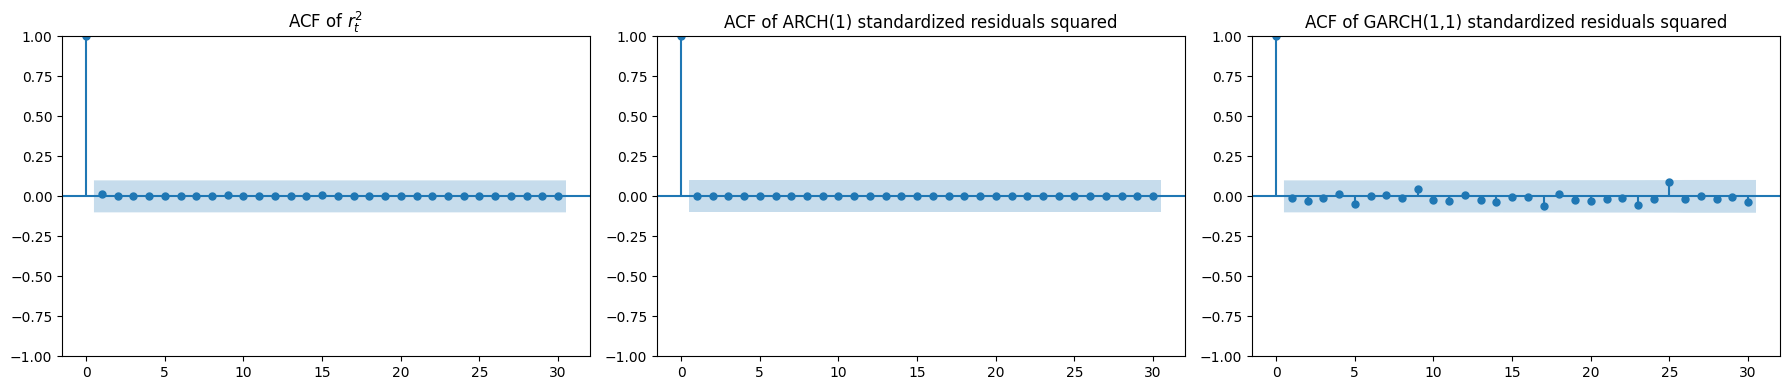

{'return_lb_pvalue': 0.9999999988237163, 'arch_bic': 267383.25027672964, 'garch_bic': -3738.954349566064, 'arch_resid_sq_lb_pvalue': 1.0, 'garch_resid_sq_lb_pvalue': 0.9927249571369496}
Realized vlatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [2.63214161e-02 4.79499726e-01 1.00000000e-06 2.85556538e+00
 7.54660200e-04]
Log-likelihood value: -69010.6732547236


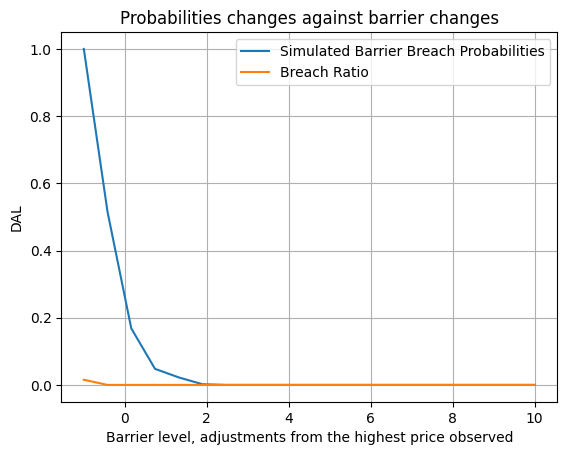

In [301]:
barrier_breach_prob_test('DAL','1m', adjustments, 1000)

[*********************100%***********************]  1 of 1 completed


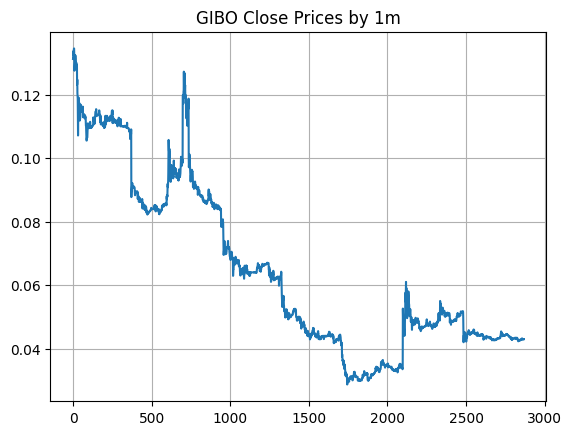

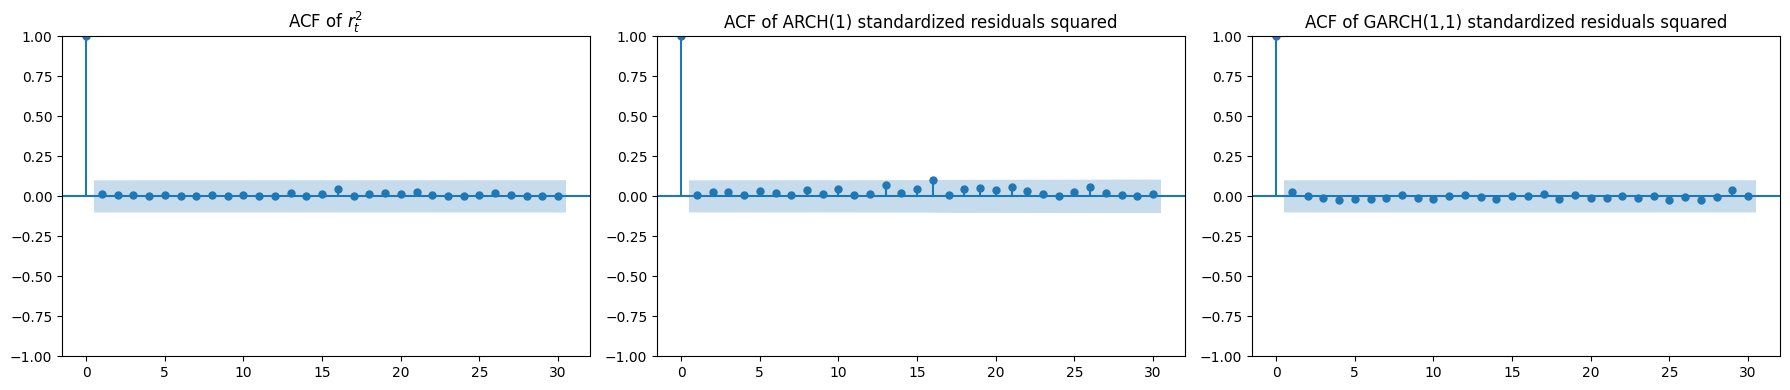

{'return_lb_pvalue': 0.9999995777910569, 'arch_bic': -1382.4311794044472, 'garch_bic': -2250.2495667703342, 'arch_resid_sq_lb_pvalue': 0.9848357124641296, 'garch_resid_sq_lb_pvalue': 0.9998598991687596}
Realized vlatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [2.00000000e+00 1.58541075e+00 1.00000000e-06 5.76869395e+00
 2.70412555e-03]
Log-likelihood value: -61552.96432130839


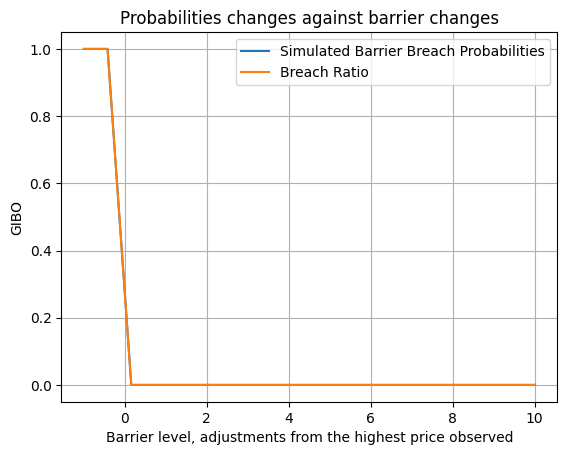

In [302]:
barrier_breach_prob_test('GIBO','1m', adjustments, 1000)

[*********************100%***********************]  1 of 1 completed


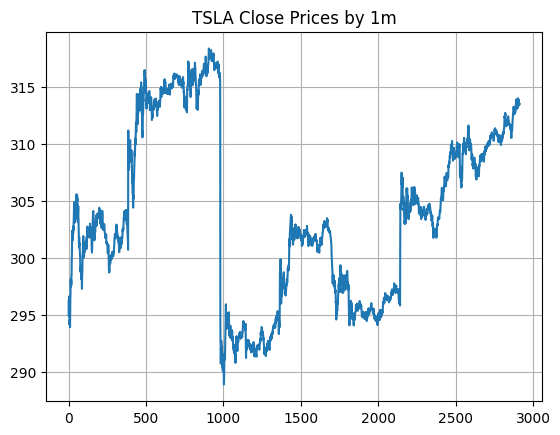

c:\Users\insan\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\insan\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


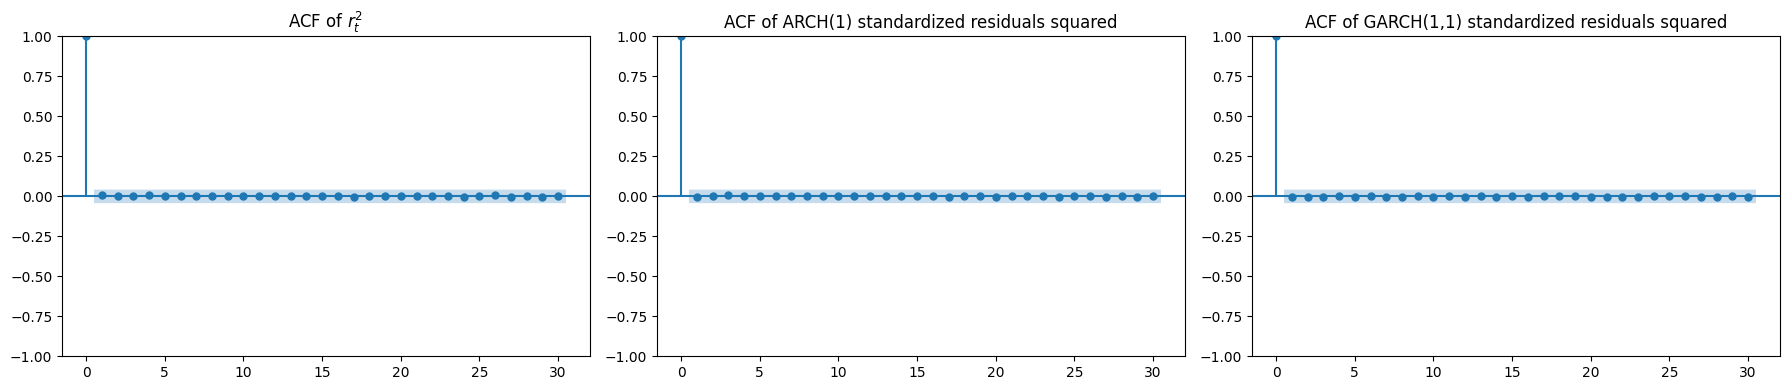

{'return_lb_pvalue': 0.9999995754683959, 'arch_bic': -21192.56383802715, 'garch_bic': -17805.09612684075, 'arch_resid_sq_lb_pvalue': 0.9999999801240942, 'garch_resid_sq_lb_pvalue': 0.9999999994501586}
Realized vlatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [-4.66637112e-03  1.04634116e+00  1.00000000e-06  1.00000000e+01
 -8.92196754e-05]
Log-likelihood value: -404112.1419868452


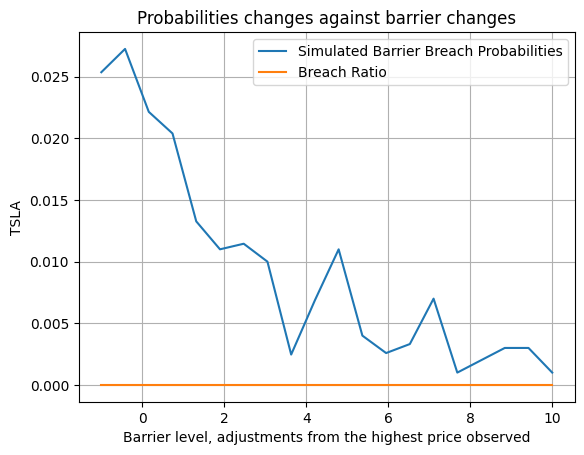

In [303]:
barrier_breach_prob_test('TSLA','1m', adjustments, 1000)

[*********************100%***********************]  1 of 1 completed


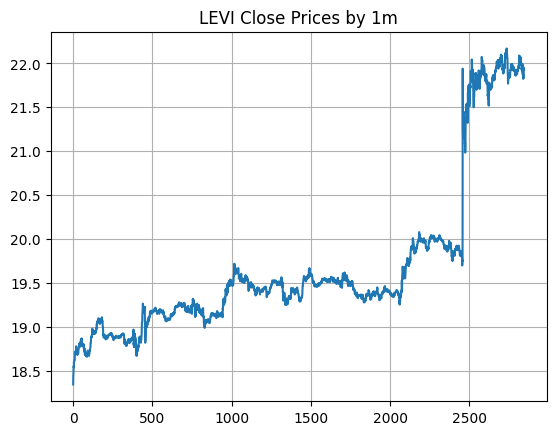

c:\Users\insan\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


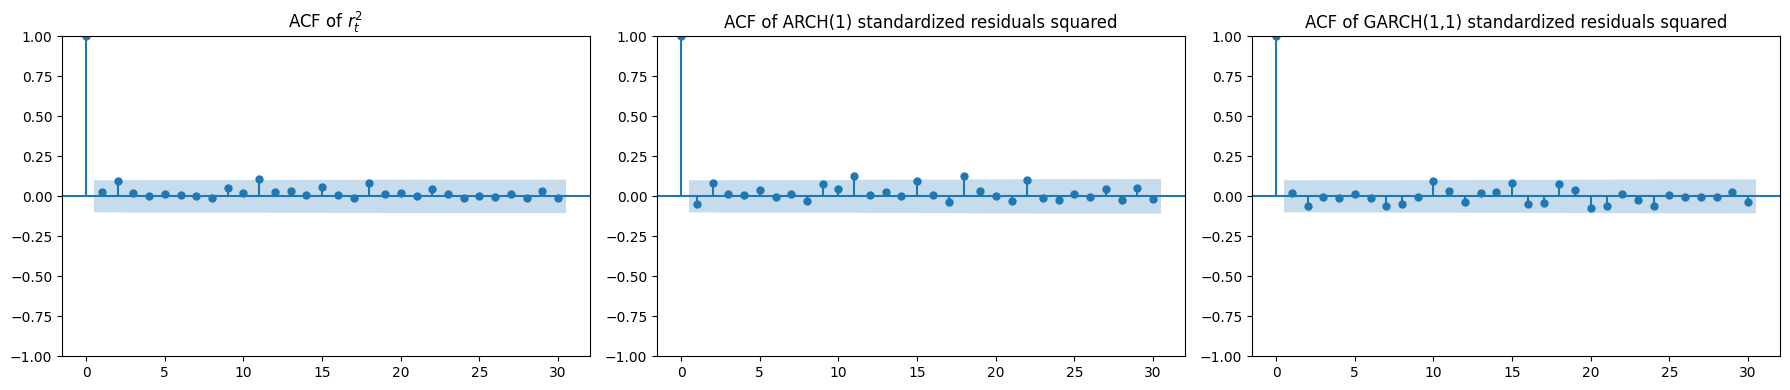

{'return_lb_pvalue': 0.865011694707969, 'arch_bic': -4070.2404511645495, 'garch_bic': -4099.9182350983265, 'arch_resid_sq_lb_pvalue': 0.6718897855338554, 'garch_resid_sq_lb_pvalue': 0.6875590755355584}
Realized vlatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [ 7.78215338e-04  2.46876257e-01  1.00000000e-06  1.68700242e+00
 -4.65427329e-05]
Log-likelihood value: -59504.79314542622


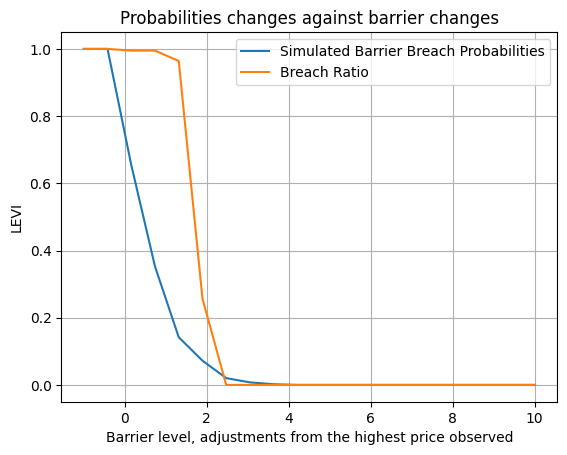

In [304]:
barrier_breach_prob_test('LEVI','1m', adjustments, 1000)

[*********************100%***********************]  1 of 1 completed


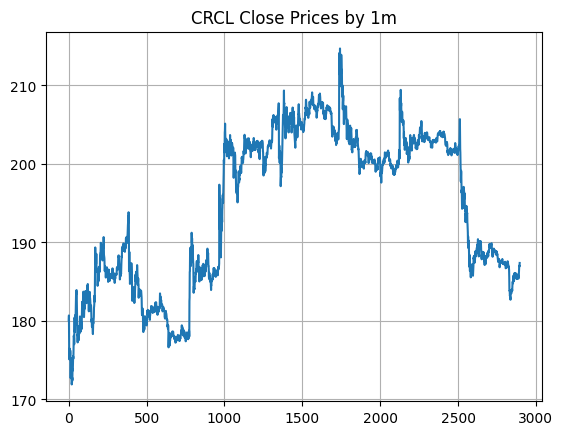

c:\Users\insan\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


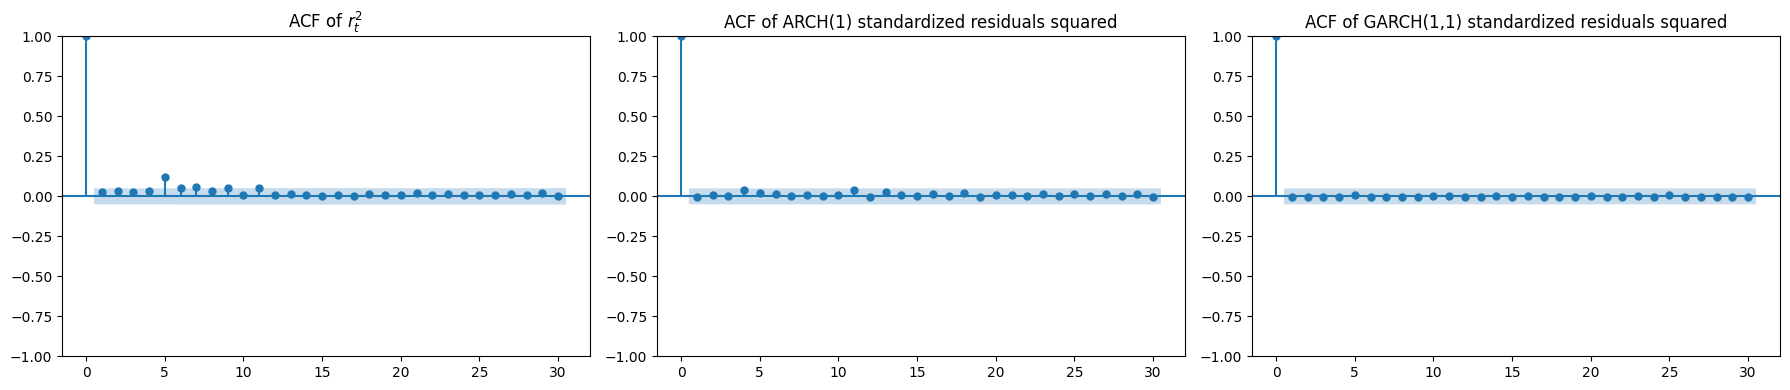

{'return_lb_pvalue': 3.6542824410571807e-06, 'arch_bic': -13551.591808746283, 'garch_bic': -13709.083195844703, 'arch_resid_sq_lb_pvalue': 0.9506795366239862, 'garch_resid_sq_lb_pvalue': 0.9999997547039986}
GARCH modeled volatility selected!
Success: True
Fitted parameters (mu, kappa, theta, sigma, rho): [6.23203605e-01 1.16687556e-02 1.00000000e-06 1.38028689e-02
 1.79927430e-04]
Log-likelihood value: -341555.6919627214


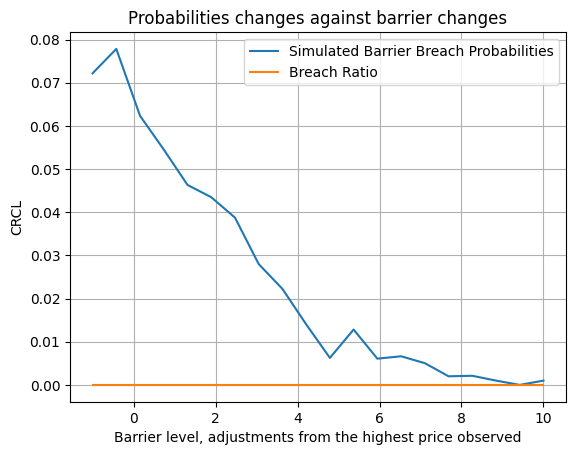

In [305]:
barrier_breach_prob_test('CRCL','1m', adjustments, 1000)